In [1]:
!pip install -q pyomo

     |████████████████████████████████| 8.9MB 7.3MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 


In [2]:
from pyomo.environ import *

In [3]:
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64

In [5]:
from __future__ import division
from pyomo.environ import *
from pyomo.dae import *
import matplotlib.pyplot as plt
import matplotlib
import gc


# matplotlib.use("pgf")
# #matplotlib.use('Qt5Agg')
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.size": 14,
})


def policy_opt_fun(params,t_in,t_f,n_pwl, i_peak):

    # Time horizon
    m = ConcreteModel()
    m.t = ContinuousSet(bounds=(t_in, t_f))
    m.t_horizon = Param(initialize = t_f)
    m.n_pwl = Param(initialize= n_pwl)
    m.t_cons = RangeSet(1, m.n_pwl)

    # Infected peak
    m.i_peak = Param(initialize=i_peak)

    # Parameter definitions
    m.alpha_e = Var(m.t, initialize=0.02, bounds=(0.05, 0.5))
    m.alpha_e_cons = Var(m.t_cons, initialize=0.03, bounds=(0.05, 0.5))
    m.alpha_e_end = Var(initialize=0.03, bounds=(0.05, 0.5))

    m.alpha_i = Var(m.t, initialize=0.05, bounds=(0.01, 0.3))
    m.alpha_i_cons = Var(m.t_cons, initialize=0.05, bounds=(0.01, 0.3))
    m.alpha_i_end = Var(initialize=0.05, bounds=(0.01, 0.3))

    m.kappa_p = Var(m.t, initialize=0.25, bounds=(0.15, 0.3))
    m.kappa_cons = Var(m.t_cons, initialize=0.25, bounds=(0.15, 0.3))
    m.kappa_end = Var(initialize=0.25, bounds=(0.15, 0.3))

    latent_val = params['latent']
    gamma_val = params['gamma']
    rho_val = params['rho']
    beta_val = params['beta']
    mu_val = params['mu']
    N_val = params['N']

    m.latent = Param(initialize=latent_val)
    m.gamma_p = Param(initialize=gamma_val)
    m.rho_p = Param(initialize=rho_val)
    m.beta_p = Param(initialize=beta_val)
    m.mu_p = Param(initialize=mu_val)
    m.N = Param(initialize=N_val)

    # State variables
    m.S = Var(m.t, bounds=(0, 1))  # Susceptible
    m.E = Var(m.t)  # Exposed
    m.A = Var(m.t, bounds=(0, 1))  # Asymptomatic
    m.I = Var(m.t, bounds=(0, 1))  # Infected
    m.R = Var(m.t, bounds=(0, 1))  # Recovered
    m.P = Var(m.t, bounds=(0, 1))  # Dead

    # Derivative variables
    m.dSdt = DerivativeVar(m.S, wrt=m.t)
    m.dEdt = DerivativeVar(m.E, wrt=m.t)
    m.dAdt = DerivativeVar(m.A, wrt=m.t)
    m.dIdt = DerivativeVar(m.I, wrt=m.t)
    m.dRdt = DerivativeVar(m.R, wrt=m.t)
    m.dPdt = DerivativeVar(m.P, wrt=m.t)

    # Initial conditions

    S0 = params['S0']
    E0 = params['E0']
    A0 = params['A0']
    I0 = params['I0']
    R0 = params['R0']
    P0 = params['P0']

    m.S[0].fix(S0)
    m.E[0].fix(E0)
    m.A[0].fix(A0)
    m.I[0].fix(I0)
    m.R[0].fix(R0)
    m.P[0].fix(P0)


    # Differential equations in the model
    def _diffeq1(m, t):
        return m.dSdt[t] == -m.alpha_e[t] * m.S[t] * m.A[t] - m.alpha_i[t] * m.S[t] * m.I[t] + m.gamma_p * m.R[t]


    m.diffeq1 = Constraint(m.t, rule=_diffeq1)


    def _diffeq2(m, t):
        return m.dEdt[t] == m.alpha_e[t] * m.S[t] * m.A[t] + m.alpha_i[t] * m.S[t] * m.I[t] - m.latent * m.E[t]


    m.diffeq2 = Constraint(m.t, rule=_diffeq2)


    def _diffeq3(m, t):
        return m.dAdt[t] == m.latent * m.E[t] - m.kappa_p[t] * m.A[t] - m.rho_p * m.A[t]


    m.diffeq3 = Constraint(m.t, rule=_diffeq3)


    def _diffeq4(m, t):
        return m.dIdt[t] == m.kappa_p[t] * m.A[t] - m.beta_p * m.I[t] - m.mu_p * m.I[t]


    m.diffeq4 = Constraint(m.t, rule=_diffeq4)


    def _diffeq5(m, t):
        return m.dRdt[t] == m.beta_p * m.I[t] - m.gamma_p * m.R[t]  + m.rho_p * m.A[t]


    m.diffeq5 = Constraint(m.t, rule=_diffeq5)


    def _diffeq6(m, t):
        return m.dPdt[t] == m.mu_p * m.I[t]


    m.diffeq6 = Constraint(m.t, rule=_diffeq6)


    # # Simulation of DAE system
    m.var_input = Suffix(direction=Suffix.LOCAL)
    m.var_input[m.kappa_p] = {0.0: 0.10000002188285406, 0.088588: 0.10000002188285406, 0.409467: 0.10000002188285406, 0.787659: 0.10000002188285406, 1.0: 0.10000002188285406, 1.088588: 0.10000002188285406, 1.409467: 0.10000002188285406, 1.787659: 0.10000002188285406, 2.0: 0.10000002188285406, 2.088588: 0.10000002188285406, 2.409467: 0.10000002188285406, 2.787659: 0.10000002188285406, 3.0: 0.10000002188285406, 3.088588: 0.10000002188285406, 3.409467: 0.10000002188285406, 3.787659: 0.10000002188285406, 4.0: 0.10000002188285406, 4.088588: 0.10000002188285406, 4.409467: 0.10000002188285406, 4.787659: 0.10000002188285406, 5.0: 0.10000001371934956, 5.088588: 0.10000001371934956, 5.409467: 0.10000001371934956, 5.787659: 0.10000001371934956, 6.0: 0.10000001371934956, 6.088588: 0.10000001371934956, 6.409467: 0.10000001371934956, 6.787659: 0.10000001371934956, 7.0: 0.10000001371934956, 7.088588: 0.10000001371934956, 7.409467: 0.10000001371934956, 7.787659: 0.10000001371934956, 8.0: 0.10000001371934956, 8.088588: 0.10000001371934956, 8.409467: 0.10000001371934956, 8.787659: 0.10000001371934956, 9.0: 0.10000001371934956, 9.088588: 0.10000001371934956, 9.409467: 0.10000001371934956, 9.787659: 0.10000001371934956, 10.0: 0.10000000469213265, 10.088588: 0.10000000469213265, 10.409467: 0.10000000469213265, 10.787659: 0.10000000469213265, 11.0: 0.10000000469213265, 11.088588: 0.10000000469213265, 11.409467: 0.10000000469213265, 11.787659: 0.10000000469213265, 12.0: 0.10000000469213265, 12.088588: 0.10000000469213265, 12.409467: 0.10000000469213265, 12.787659: 0.10000000469213265, 13.0: 0.10000000469213265, 13.088588: 0.10000000469213265, 13.409467: 0.10000000469213265, 13.787659: 0.10000000469213265, 14.0: 0.10000000469213265, 14.088588: 0.10000000469213265, 14.409467: 0.10000000469213265, 14.787659: 0.10000000469213265, 15.0: 0.1, 15.088588: 0.1, 15.409467: 0.1, 15.787659: 0.1, 16.0: 0.1, 16.088588: 0.1, 16.409467: 0.1, 16.787659: 0.1, 17.0: 0.1, 17.088588: 0.1, 17.409467: 0.1, 17.787659: 0.1, 18.0: 0.1, 18.088588: 0.1, 18.409467: 0.1, 18.787659: 0.1, 19.0: 0.1, 19.088588: 0.1, 19.409467: 0.1, 19.787659: 0.1, 20.0: 0.1, 20.088588: 0.1, 20.409467: 0.1, 20.787659: 0.1, 21.0: 0.1, 21.088588: 0.1, 21.409467: 0.1, 21.787659: 0.1, 22.0: 0.1, 22.088588: 0.1, 22.409467: 0.1, 22.787659: 0.1, 23.0: 0.1, 23.088588: 0.1, 23.409467: 0.1, 23.787659: 0.1, 24.0: 0.1, 24.088588: 0.1, 24.409467: 0.1, 24.787659: 0.1, 25.0: 0.1, 25.088588: 0.1, 25.409467: 0.1, 25.787659: 0.1, 26.0: 0.1, 26.088588: 0.1, 26.409467: 0.1, 26.787659: 0.1, 27.0: 0.1, 27.088588: 0.1, 27.409467: 0.1, 27.787659: 0.1, 28.0: 0.1, 28.088588: 0.1, 28.409467: 0.1, 28.787659: 0.1, 29.0: 0.1, 29.088588: 0.1, 29.409467: 0.1, 29.787659: 0.1, 30.0: 0.1, 30.088588: 0.1, 30.409467: 0.1, 30.787659: 0.1, 31.0: 0.1, 31.088588: 0.1, 31.409467: 0.1, 31.787659: 0.1, 32.0: 0.1, 32.088588: 0.1, 32.409467: 0.1, 32.787659: 0.1, 33.0: 0.1, 33.088588: 0.1, 33.409467: 0.1, 33.787659: 0.1, 34.0: 0.1, 34.088588: 0.1, 34.409467: 0.1, 34.787659: 0.1, 35.0: 0.1, 35.088588: 0.1, 35.409467: 0.1, 35.787659: 0.1, 36.0: 0.1, 36.088588: 0.1, 36.409467: 0.1, 36.787659: 0.1, 37.0: 0.1, 37.088588: 0.1, 37.409467: 0.1, 37.787659: 0.1, 38.0: 0.1, 38.088588: 0.1, 38.409467: 0.1, 38.787659: 0.1, 39.0: 0.1, 39.088588: 0.1, 39.409467: 0.1, 39.787659: 0.1, 40.0: 0.1, 40.088588: 0.1, 40.409467: 0.1, 40.787659: 0.1, 41.0: 0.1, 41.088588: 0.1, 41.409467: 0.1, 41.787659: 0.1, 42.0: 0.1, 42.088588: 0.1, 42.409467: 0.1, 42.787659: 0.1, 43.0: 0.1, 43.088588: 0.1, 43.409467: 0.1, 43.787659: 0.1, 44.0: 0.1, 44.088588: 0.1, 44.409467: 0.1, 44.787659: 0.1, 45.0: 0.1, 45.088588: 0.1, 45.409467: 0.1, 45.787659: 0.1, 46.0: 0.1, 46.088588: 0.1, 46.409467: 0.1, 46.787659: 0.1, 47.0: 0.1, 47.088588: 0.1, 47.409467: 0.1, 47.787659: 0.1, 48.0: 0.1, 48.088588: 0.1, 48.409467: 0.1, 48.787659: 0.1, 49.0: 0.1, 49.088588: 0.1, 49.409467: 0.1, 49.787659: 0.1, 50.0: 0.1}
    m.var_input[m.alpha_e] = {0.0: 0.4999999677806888, 0.088588: 0.4999999677806888, 0.409467: 0.4999999677806888, 0.787659: 0.4999999677806888, 1.0: 0.4999999677806888, 1.088588: 0.4999999677806888, 1.409467: 0.4999999677806888, 1.787659: 0.4999999677806888, 2.0: 0.4999999677806888, 2.088588: 0.4999999677806888, 2.409467: 0.4999999677806888, 2.787659: 0.4999999677806888, 3.0: 0.4999999677806888, 3.088588: 0.4999999677806888, 3.409467: 0.4999999677806888, 3.787659: 0.4999999677806888, 4.0: 0.4999999677806888, 4.088588: 0.4999999677806888, 4.409467: 0.4999999677806888, 4.787659: 0.4999999677806888, 5.0: 0.4999999757101205, 5.088588: 0.4999999757101205, 5.409467: 0.4999999757101205, 5.787659: 0.4999999757101205, 6.0: 0.4999999757101205, 6.088588: 0.4999999757101205, 6.409467: 0.4999999757101205, 6.787659: 0.4999999757101205, 7.0: 0.4999999757101205, 7.088588: 0.4999999757101205, 7.409467: 0.4999999757101205, 7.787659: 0.4999999757101205, 8.0: 0.4999999757101205, 8.088588: 0.4999999757101205, 8.409467: 0.4999999757101205, 8.787659: 0.4999999757101205, 9.0: 0.4999999757101205, 9.088588: 0.4999999757101205, 9.409467: 0.4999999757101205, 9.787659: 0.4999999757101205, 10.0: 0.49999998472271, 10.088588: 0.49999998472271, 10.409467: 0.49999998472271, 10.787659: 0.49999998472271, 11.0: 0.49999998472271, 11.088588: 0.49999998472271, 11.409467: 0.49999998472271, 11.787659: 0.49999998472271, 12.0: 0.49999998472271, 12.088588: 0.49999998472271, 12.409467: 0.49999998472271, 12.787659: 0.49999998472271, 13.0: 0.49999998472271, 13.088588: 0.49999998472271, 13.409467: 0.49999998472271, 13.787659: 0.49999998472271, 14.0: 0.49999998472271, 14.088588: 0.49999998472271, 14.409467: 0.49999998472271, 14.787659: 0.49999998472271, 15.0: 0.4999999940692952, 15.088588: 0.4999999940692952, 15.409467: 0.4999999940692952, 15.787659: 0.4999999940692952, 16.0: 0.4999999940692952, 16.088588: 0.4999999940692952, 16.409467: 0.4999999940692952, 16.787659: 0.4999999940692952, 17.0: 0.4999999940692952, 17.088588: 0.4999999940692952, 17.409467: 0.4999999940692952, 17.787659: 0.4999999940692952, 18.0: 0.4999999940692952, 18.088588: 0.4999999940692952, 18.409467: 0.4999999940692952, 18.787659: 0.4999999940692952, 19.0: 0.4999999940692952, 19.088588: 0.4999999940692952, 19.409467: 0.4999999940692952, 19.787659: 0.5, 20.0: 0.5, 20.088588: 0.5, 20.409467: 0.5, 20.787659: 0.5, 21.0: 0.5, 21.088588: 0.5, 21.409467: 0.5, 21.787659: 0.5, 22.0: 0.5, 22.088588: 0.5, 22.409467: 0.5, 22.787659: 0.5, 23.0: 0.5, 23.088588: 0.5, 23.409467: 0.5, 23.787659: 0.5, 24.0: 0.5, 24.088588: 0.5, 24.409467: 0.5, 24.787659: 0.5, 25.0: 0.5, 25.088588: 0.5, 25.409467: 0.5, 25.787659: 0.5, 26.0: 0.5, 26.088588: 0.5, 26.409467: 0.5, 26.787659: 0.5, 27.0: 0.5, 27.088588: 0.5, 27.409467: 0.5, 27.787659: 0.5, 28.0: 0.5, 28.088588: 0.5, 28.409467: 0.5, 28.787659: 0.5, 29.0: 0.5, 29.088588: 0.5, 29.409467: 0.5, 29.787659: 0.5, 30.0: 0.5, 30.088588: 0.5, 30.409467: 0.5, 30.787659: 0.5, 31.0: 0.5, 31.088588: 0.5, 31.409467: 0.5, 31.787659: 0.5, 32.0: 0.5, 32.088588: 0.5, 32.409467: 0.5, 32.787659: 0.5, 33.0: 0.5, 33.088588: 0.5, 33.409467: 0.5, 33.787659: 0.5, 34.0: 0.5, 34.088588: 0.5, 34.409467: 0.5, 34.787659: 0.5, 35.0: 0.5, 35.088588: 0.5, 35.409467: 0.5, 35.787659: 0.5, 36.0: 0.5, 36.088588: 0.5, 36.409467: 0.5, 36.787659: 0.5, 37.0: 0.5, 37.088588: 0.5, 37.409467: 0.5, 37.787659: 0.5, 38.0: 0.5, 38.088588: 0.5, 38.409467: 0.5, 38.787659: 0.5, 39.0: 0.5, 39.088588: 0.5, 39.409467: 0.5, 39.787659: 0.5, 40.0: 0.5, 40.088588: 0.5, 40.409467: 0.5, 40.787659: 0.5, 41.0: 0.5, 41.088588: 0.5, 41.409467: 0.5, 41.787659: 0.5, 42.0: 0.5, 42.088588: 0.5, 42.409467: 0.5, 42.787659: 0.5, 43.0: 0.5, 43.088588: 0.5, 43.409467: 0.5, 43.787659: 0.5, 44.0: 0.5, 44.088588: 0.5, 44.409467: 0.5, 44.787659: 0.5, 45.0: 0.5, 45.088588: 0.5, 45.409467: 0.5, 45.787659: 0.5, 46.0: 0.5, 46.088588: 0.5, 46.409467: 0.5, 46.787659: 0.5, 47.0: 0.5, 47.088588: 0.5, 47.409467: 0.5, 47.787659: 0.5, 48.0: 0.5, 48.088588: 0.5, 48.409467: 0.5, 48.787659: 0.5, 49.0: 0.5, 49.088588: 0.5, 49.409467: 0.5, 49.787659: 0.5, 50.0: 0.5}
    m.var_input[m.alpha_i] = {0.0: 0.2999999609296359, 0.088588: 0.2999999609296359, 0.409467: 0.2999999609296359, 0.787659: 0.2999999609296359, 1.0: 0.2999999609296359, 1.088588: 0.2999999609296359, 1.409467: 0.2999999609296359, 1.787659: 0.2999999609296359, 2.0: 0.2999999609296359, 2.088588: 0.2999999609296359, 2.409467: 0.2999999609296359, 2.787659: 0.2999999609296359, 3.0: 0.2999999609296359, 3.088588: 0.2999999609296359, 3.409467: 0.2999999609296359, 3.787659: 0.2999999609296359, 4.0: 0.2999999609296359, 4.088588: 0.2999999609296359, 4.409467: 0.2999999609296359, 4.787659: 0.2999999609296359, 5.0: 0.2999999685771003, 5.088588: 0.2999999685771003, 5.409467: 0.2999999685771003, 5.787659: 0.2999999685771003, 6.0: 0.2999999685771003, 6.088588: 0.2999999685771003, 6.409467: 0.2999999685771003, 6.787659: 0.2999999685771003, 7.0: 0.2999999685771003, 7.088588: 0.2999999685771003, 7.409467: 0.2999999685771003, 7.787659: 0.2999999685771003, 8.0: 0.2999999685771003, 8.088588: 0.2999999685771003, 8.409467: 0.2999999685771003, 8.787659: 0.2999999685771003, 9.0: 0.2999999685771003, 9.088588: 0.2999999685771003, 9.409467: 0.2999999685771003, 9.787659: 0.2999999685771003, 10.0: 0.2999999774696616, 10.088588: 0.2999999774696616, 10.409467: 0.2999999774696616, 10.787659: 0.2999999774696616, 11.0: 0.2999999774696616, 11.088588: 0.2999999774696616, 11.409467: 0.2999999774696616, 11.787659: 0.2999999774696616, 12.0: 0.2999999774696616, 12.088588: 0.2999999774696616, 12.409467: 0.2999999774696616, 12.787659: 0.2999999774696616, 13.0: 0.2999999774696616, 13.088588: 0.2999999774696616, 13.409467: 0.2999999774696616, 13.787659: 0.2999999774696616, 14.0: 0.2999999774696616, 14.088588: 0.2999999774696616, 14.409467: 0.2999999774696616, 14.787659: 0.2999999774696616, 15.0: 0.29999998676672485, 15.088588: 0.29999998676672485, 15.409467: 0.29999998676672485, 15.787659: 0.29999998676672485, 16.0: 0.29999998676672485, 16.088588: 0.29999998676672485, 16.409467: 0.29999998676672485, 16.787659: 0.29999998676672485, 17.0: 0.29999998676672485, 17.088588: 0.29999998676672485, 17.409467: 0.29999998676672485, 17.787659: 0.29999998676672485, 18.0: 0.29999998676672485, 18.088588: 0.29999998676672485, 18.409467: 0.29999998676672485, 18.787659: 0.29999998676672485, 19.0: 0.29999998676672485, 19.088588: 0.29999998676672485, 19.409467: 0.29999998676672485, 19.787659: 0.2999999962289412, 20.0: 0.2999999962289412, 20.088588: 0.2999999962289412, 20.409467: 0.2999999962289412, 20.787659: 0.2999999962289412, 21.0: 0.2999999962289412, 21.088588: 0.2999999962289412, 21.409467: 0.2999999962289412, 21.787659: 0.2999999962289412, 22.0: 0.2999999962289412, 22.088588: 0.2999999962289412, 22.409467: 0.2999999962289412, 22.787659: 0.2999999962289412, 23.0: 0.2999999962289412, 23.088588: 0.2999999962289412, 23.409467: 0.2999999962289412, 23.787659: 0.2999999962289412, 24.0: 0.2999999962289412, 24.088588: 0.2999999962289412, 24.409467: 0.2999999962289412, 24.787659: 0.3, 25.0: 0.3, 25.088588: 0.3, 25.409467: 0.3, 25.787659: 0.3, 26.0: 0.3, 26.088588: 0.3, 26.409467: 0.3, 26.787659: 0.3, 27.0: 0.3, 27.088588: 0.3, 27.409467: 0.3, 27.787659: 0.3, 28.0: 0.3, 28.088588: 0.3, 28.409467: 0.3, 28.787659: 0.3, 29.0: 0.3, 29.088588: 0.3, 29.409467: 0.3, 29.787659: 0.3, 30.0: 0.3, 30.088588: 0.3, 30.409467: 0.3, 30.787659: 0.3, 31.0: 0.3, 31.088588: 0.3, 31.409467: 0.3, 31.787659: 0.3, 32.0: 0.3, 32.088588: 0.3, 32.409467: 0.3, 32.787659: 0.3, 33.0: 0.3, 33.088588: 0.3, 33.409467: 0.3, 33.787659: 0.3, 34.0: 0.3, 34.088588: 0.3, 34.409467: 0.3, 34.787659: 0.3, 35.0: 0.3, 35.088588: 0.3, 35.409467: 0.3, 35.787659: 0.3, 36.0: 0.3, 36.088588: 0.3, 36.409467: 0.3, 36.787659: 0.3, 37.0: 0.3, 37.088588: 0.3, 37.409467: 0.3, 37.787659: 0.3, 38.0: 0.3, 38.088588: 0.3, 38.409467: 0.3, 38.787659: 0.3, 39.0: 0.3, 39.088588: 0.3, 39.409467: 0.3, 39.787659: 0.3, 40.0: 0.3, 40.088588: 0.3, 40.409467: 0.3, 40.787659: 0.3, 41.0: 0.3, 41.088588: 0.3, 41.409467: 0.3, 41.787659: 0.3, 42.0: 0.3, 42.088588: 0.3, 42.409467: 0.3, 42.787659: 0.3, 43.0: 0.3, 43.088588: 0.3, 43.409467: 0.3, 43.787659: 0.3, 44.0: 0.3, 44.088588: 0.3, 44.409467: 0.3, 44.787659: 0.3, 45.0: 0.3, 45.088588: 0.3, 45.409467: 0.3, 45.787659: 0.3, 46.0: 0.3, 46.088588: 0.3, 46.409467: 0.3, 46.787659: 0.3, 47.0: 0.3, 47.088588: 0.3, 47.409467: 0.3, 47.787659: 0.3, 48.0: 0.3, 48.088588: 0.3, 48.409467: 0.3, 48.787659: 0.3, 49.0: 0.3, 49.088588: 0.3, 49.409467: 0.3, 49.787659: 0.3, 50.0: 0.3}


    sim = Simulator(m, package='scipy')
    t_sim, sol = sim.simulate(integrator='vode', numpoints=500, varying_inputs=m.var_input)

    # #  Discretize model using radau collocation
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(m, wrt=m.t, nfe=int(t_f-t_in), ncp=3)


    def obj_fun(m):
        return sum(1/3*(1 - m.alpha_i[t]) + 1/3*(1 - m.alpha_e[t]) - 0.1 * m.kappa_p[t] for t in m.t)

    m.obj = Objective(rule=obj_fun, sense=minimize)




    def Imax__rule(m, t):
        return m.i_peak >= m.N*m.I[t]


    m.Imax__rule = Constraint(m.t, rule=Imax__rule)


    # Enforcing piecewise linear parameter values
    def alpha_e_pwl_rule(m, t):
        t_int = m.t_horizon / m.n_pwl
        t_discrete = int(t / t_int) + 1
        if t >= value(m.t_horizon):
            t_discrete = int(t / t_int)
        return m.alpha_e[t] == m.alpha_e_cons[t_discrete]


    m.alpha_e_pwl = Constraint(m.t, rule=alpha_e_pwl_rule)


    def alpha_i_pwl_rule(m, t):
        t_int = m.t_horizon / m.n_pwl
        t_discrete = int(t / t_int) + 1
        if t >= value(m.t_horizon):
            t_discrete = int(t / t_int)
        return m.alpha_i[t] == m.alpha_i_cons[t_discrete]


    m.alpha_i_pwl = Constraint(m.t, rule=alpha_i_pwl_rule)


    def kappa_pwl_rule(m, t):
        t_int = m.t_horizon / m.n_pwl
        t_discrete = int(t / t_int) + 1
        if t >= value(m.t_horizon):
            t_discrete = int(t / t_int)
        return m.kappa_p[t] == m.kappa_cons[t_discrete]

    m.kappa_pwl = Constraint(m.t, rule=kappa_pwl_rule)

    def kappa_ub_rule(m,t):
        if t >= t_f:
            return m.kappa_p[t] == 0.3
        else:
            return Constraint.Skip

    m.kappa_ub = Constraint(m.t, rule = kappa_ub_rule)

    def alpha_e_ub_rule(m,t):
        if t >= t_f:
            return m.alpha_e[t] == 0.05
        else:
            return Constraint.Skip

    m.alpha_e_ub = Constraint(m.t, rule = alpha_e_ub_rule)

    sim.initialize_model()

    solver = SolverFactory('ipopt')
    solver.options['mu_init'] = 1e-6
    solver.options['print_user_options'] = 'yes'
    results = solver.solve(m, tee=True)

    return m

def plotting_fun(m):

    S = []
    E = []
    A = []
    I = []
    R = []
    P = []
    t = []
    kappa_p = []
    alpha_e = []
    alpha_i = []

    for i in sorted(m.t):
        t.append(i)
        S.append(value(m.N*m.S[i])/1e3)
        E.append(value(m.N*m.E[i])/1e3)
        A.append(value(m.N*m.A[i])/1e3)
        I.append(value(m.N*m.I[i])/1e3)
        R.append(value(m.N*m.R[i])/1e3)
        P.append(value(m.N*m.P[i])/1e3)
        kappa_p.append(value(m.kappa_p[i]))
        alpha_e.append(value(m.alpha_e[i]))
        alpha_i.append(value(m.alpha_i[i]))

    alpha_i_dict, alpha_e_dict, kappa_dict = {}, {}, {}
    i = 0
    for j in t:
        alpha_i_dict[j], alpha_e_dict[j], kappa_dict[j] = alpha_i[i], alpha_e[i], kappa_p[i]
        i += 1


    # plt.plot(t, S, label='S')
    fig = plt.figure(figsize=(8, 7))
    plt.subplot(211)
    plt.plot(t, E, label='E')
    plt.plot(t, A, label='A')
    plt.plot(t, I, label='I')
    plt.plot(t, R, label='R')
    plt.plot(t, P, label='P')
    plt.xlabel('Time (days)')
    plt.ylabel('Subjects (thousands)')
    plt.tick_params(axis='both', direction='in', top=True, right=True)
    plt.legend(loc='best', ncol = 5)
    plt.grid()

    plt.subplot(212)
    plt.plot(t, alpha_e, 'b', label=r'$\alpha_e(t)$')
    plt.plot(t, alpha_i, 'k', label=r'$\alpha_i(t)$')
    plt.plot(t, kappa_p, 'r', label=r'$\kappa(t)$')
    plt.legend(loc='best')
    plt.grid()
    plt.xlabel('Time (days)')
    plt.ylabel('Inputs')
    plt.tick_params(axis='both', direction='in', top=True, right=True)
    plt.draw()



    plt.show()


gc.collect()

0

Ipopt 3.12.13: mu_init=1e-06
print_user_options=yes


List of user-set options:

                                    Name   Value                used
                                 mu_init = 1e-06                 yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    28460
Number of nonzeros in inequality constraint Jacobian.:      459
Number of nonzeros in Lagrangian Hessian............

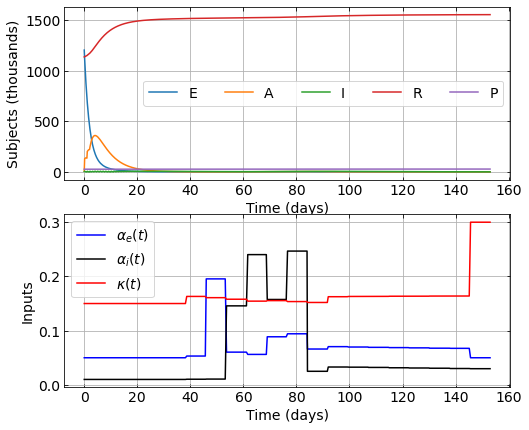

<Figure size 432x288 with 0 Axes>

In [6]:
params = {}
params['latent'], params['gamma'], params['rho'], params['beta'] = [0.50000, 0, 0.10000, 0.07234]
params['mu'], params['N'] = [0.002779, 19107000]
params['S0'] = 0.936945884
params['E0'] = 0.0630541163
params['A0'] = 0.000338567017

params['I0'] = 4285.0/params['N']
params['R0'] = 1136816.0/params['N']
params['P0'] = 26457.0/params['N']

'''Optimal control function.
    Inputs: 
        - params: SEAIRP model parameters 
        - t_init: initial time point 
        - t_f: final time point
        - n_pwl: number of piece-wise linear segments for inputs
        - i_peak: infeacted peak'''
m = policy_opt_fun(params,0,153,20,6000)
plotting_fun(m)


plt.draw()
